# Primer design

Optimal primer design for Bsa1 involves several key considerations for Golden Gate cloning or other PCR applications. 
Primers should be 18-24 base pairs long, 
have a GC content of 40-60%
end in G or C for a "GC clamp" to enhance binding. 

Avoiding secondary structures and primer dimers is also crucial. Specific primers for a particular application (e.g., Golden Gate cloning with BsaI) will also need to incorporate the BsaI recognition sequence. 

#### Primer Design Guidelines:
Length: 18-24 base pairs. 
GC Content: Aim for 40-60%, with 50-55% being ideal.   
Tm (Melting Temperature): Strive for a Tm between 50 and 65°C.   
GC Clamp: Consider ending the 3' end of the primer with a G or C.   
Avoid Repeats: Minimize long runs of Gs or Cs.   
Secondary Structure: Design primers to avoid regions of high secondary structure in the target sequence.   
Primer Dimers: Ensure primers do not form dimers, which can interfere with PCR.   


CGCCGCGGCCGC-GGTCTC-C-NNNNNNNNNNN-C-GGTCTC-CGCGGGGCGGCG

In [1]:
#! pip install pyswarms

In [5]:
# Designing primers for BSA1 
from oligopoolio import *


bsa1_site = 'GGTCTC'

primer_min, primer_max = 18, 24
gc_optimal = 0.5
tm_optimal = 0.65
structure_dg = 0 # aim for greater than 0

# Probably best to use something like pyswarm 


In [10]:
import pyswarms as ps
import numpy as np
import itertools
from primer3 import calc_hairpin, calc_homodimer

nt_to_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
index_to_nt = {v: k for k, v in nt_to_index.items()}

def encode_primer(seq):
    return np.array([nt_to_index[nt] for nt in seq])

def decode_primer(arr):
    rounded = np.clip(np.round(arr), 0, 3).astype(int)
    return ''.join(index_to_nt[i] for i in rounded)

def gc_content(seq):
    return (seq.count('G') + seq.count('C')) / len(seq)

def objective_function(x):
    penalties = []
    for row in x:
        seq = decode_primer(row)
        clamp_penalty = 0
        if (seq[0] != 'G' and seq[0] != 'C') or (seq[-1] != 'G' and seq[-1] != 'C'):
            clamp_penalty = 10
        seq += bsa1_site_fwd
        gc = gc_content(seq)
        tm = melting_temp(seq)

        results = check_secondary_structure(seq)
        homodimer_tm = results['homodimer']['homodimer_dg']
        hairpin_tm = results['hairpin']['hairpin_dg']
        
        # Penalize if Tm deviates from 60
        primer_tm = primer3.bindings.calcTm(seq)

        tm_penalty = np.abs(primer_tm - tm_optimal)*5
        
        # Penalize if GC content is far from 0.5
        gc_penalty = np.abs(gc - gc_optimal)*5
        
        # Example: simple penalty for homopolymer runs
        homodimer_tm = 0 if homodimer_tm > 0 else np.abs(homodimer_tm)
        penalties.append(tm_penalty + gc_penalty + homodimer_tm + clamp_penalty)
    return np.array(penalties)

def check_secondary_structure(sequence, temp=55):
    """
    Check secondary structures like hairpins and homodimers in a given primer sequence.
    
    Args:
        sequence (str): The DNA sequence of the primer to analyze.
        
    Returns:
        dict: Results for hairpin and homodimer properties.
    """
    try:
        # Check for hairpin structure
        hairpin_result = calc_hairpin(sequence, temp_c=temp)
        hairpin_info = {
            "hairpin_found": hairpin_result.structure_found,
            "hairpin_tm": hairpin_result.tm,
            "hairpin_dg": hairpin_result.dg/1000,
            "hairpin_dh": hairpin_result.dh/1000,
            "hairpin_ds": hairpin_result.ds,
        }

        # Check for homodimer structure
        homodimer_result = calc_homodimer(sequence, temp_c=temp)
        homodimer_info = {
            "homodimer_found": homodimer_result.structure_found,
            "homodimer_tm": homodimer_result.tm,
            "homodimer_dg": homodimer_result.dg/1000,
            "homodimer_dh": homodimer_result.dh/1000,
            "homodimer_ds": homodimer_result.ds,
        }
    except Exception as e:
        u.warn_p([f"Warning: issue with secondary structure check. ", sequence, e])
        hairpin_info = {"hairpin_found": False, "hairpin_tm": None, "hairpin_dg": None, "hairpin_dh": None, "hairpin_ds": None}
        homodimer_info = {"homodimer_found": False, "homodimer_tm": None, "homodimer_dg": None, "homodimer_dh": None, "homodimer_ds": None}
    # Combine results
    return {"hairpin": hairpin_info, "homodimer": homodimer_info}

In [17]:
from sciutil import SciUtil
import random
import Levenshtein

u = SciUtil()

bsa1_site_fwd = 'GGTCTCC'
bsa1_site_rv =  'GGTCTC'

primer_min, primer_max = 18, 24
gc_optimal = 0.5
tm_optimal = 55
structure_dg = 0 # aim for greater than 0

# Probably best to use something like pyswarm 

options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9} 
num_sequences = 100
seq_ids = []
sequences = []
for sample in range(0, num_sequences):
    primer_len = 11 # random.sample(range(16, 20), 1)[0]
    bounds = (np.zeros(primer_len), np.ones(primer_len) * 3)
    
    optimizer = ps.single.GlobalBestPSO(
        n_particles=50,
        dimensions=primer_len,
        options=options,
        bounds=bounds
    )

    best_cost, best_pos = optimizer.optimize(objective_function, iters=200)
    best_primer = decode_primer(best_pos)
    best_primer = bsa1_site_fwd + best_primer
    gc = gc_content(best_primer)
    tm = melting_temp(best_primer)
    results = check_secondary_structure(best_primer)
    homodimer_tm = results['homodimer']['homodimer_dg']
    hairpin_tm = results['hairpin']['hairpin_dg']
    seq_ids.append(f'tm:{tm} gc:{round(gc, 2)} dg:{round(homodimer_tm, 2)}')
    u.dp(['Best primer', len(best_primer), best_primer, f'tm:{tm}', f'gc:{gc}', f'dg:{homodimer_tm}'])
    sequences.append(best_primer)


2025-04-23 10:07:24,118 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|                                                                                                                                                                  |0/200/Users/arianemora/miniconda3/envs/oligo/lib/python3.10/site-packages/primer3/bindings.py:489: UserWarning: Function deprecated please use "calc_tm" instead
  return THERMO_ANALYSIS.calcTm(seq)
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:07:24,971 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.9519533  2.94237755 2.14181878 1.92024739 2.76878619 1.9631577
 0.36031939 2.58892525 2.78440999 1.32312533 1.6608509 ]
2025-04-23 10:07:24,974 - p

--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGTGGTGATTCG	tm:58	gc:0.6111111111111112	dg:1.4661842821398667	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:07:25,854 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [2.35214413 0.08845793 0.46504693 2.5323283  2.24850443 1.66192035
 2.21767198 0.4334458  1.32906346 0.4534955  1.11907624]
2025-04-23 10:07:25,857 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGAATGGGACAC	tm:58	gc:0.6111111111111112	dg:-0.8782181648037631	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:07:26,664 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5772606096957333, best pos: [1.07340317 0.02964813 1.44220263 1.98291733 0.91487513 2.80480544
 1.64628673 2.70190526 0.18383462 0.04515717 2.14948579]
2025-04-23 10:07:26,667 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCACGCTGTAAG	tm:58	gc:0.6111111111111112	dg:-1.0970693882722953	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:07:27,500 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5773936367764976, best pos: [1.23928065 0.3921736  1.68298849 0.2520079  2.12639873 0.07423656
 0.26552266 0.44651667 1.57218617 1.25021754 2.09840388]
2025-04-23 10:07:27,530 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCAGAGAAAGCG	tm:58	gc:0.6111111111111112	dg:0.2717412821398769	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=1.32
2025-04-23 10:07:28,317 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.3221755000563662, best pos: [1.04200764 0.38597259 0.03106584 0.18368318 2.7706061  1.89150362
 2.63213068 1.89859038 1.83335208 1.9942591  2.09384348]
2025-04-23 10:07:28,320 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCAAATGTGGGG	tm:58	gc:0.6111111111111112	dg:-4.293514494398157	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:07:29,059 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5772606096957333, best pos: [1.17162415 1.61340648 1.10114224 2.77532183 0.18958221 0.69885615
 2.98052748 1.84773021 2.50647468 2.74170321 1.94904827]
2025-04-23 10:07:29,061 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCGCTACTGTTG	tm:58	gc:0.6111111111111112	dg:-0.831568164797197	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.699
2025-04-23 10:07:29,856 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.698698774499496, best pos: [1.48737509 2.80749975 2.07025018 2.57336066 0.2217229  0.33828623
 0.55759611 0.32462496 2.09452382 0.63259563 2.40954369]
2025-04-23 10:07:29,859 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTGTAACAGCG	tm:58	gc:0.6111111111111112	dg:-1.2129081648004734	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.613
2025-04-23 10:07:30,642 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6126937744994951, best pos: [1.07110836 0.58638029 2.51269775 0.43549415 1.97669159 2.52783423
 2.97542914 2.4869712  2.59535005 1.58509555 1.20596074]
2025-04-23 10:07:30,645 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCCTAGTTGTGC	tm:58	gc:0.6111111111111112	dg:-0.03543316480376181	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:07:31,427 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5772606096957333, best pos: [1.07344382 2.39332714 1.083602   2.552303   1.58855754 2.72373635
 2.80759547 0.28232654 1.12348176 2.5073884  1.64465238]
2025-04-23 10:07:31,430 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCGCTGTTACTG	tm:58	gc:0.6111111111111112	dg:-0.24977938827229298	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:07:32,213 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.34162219 0.95791159 1.55695352 1.37031036 2.97645661 2.54928955
 1.84064761 2.60780014 0.45928799 0.10198686 2.12240011]
2025-04-23 10:07:32,216 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCCGCTTGTAAG	tm:58	gc:0.6111111111111112	dg:-0.3423887765347453	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.76
2025-04-23 10:07:33,023 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7596262430553424, best pos: [1.99227532 0.16078928 0.99021182 1.68633859 2.73000269 0.27264701
 1.19898329 1.41467896 0.46208649 0.20938819 1.46075956]
2025-04-23 10:07:33,026 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGACGTACCAAC	tm:58	gc:0.6111111111111112	dg:0.9797075056018414	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.672
2025-04-23 10:07:33,809 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6718859240183606, best pos: [1.38100223 0.39771544 2.6849891  1.76676614 1.84007259 0.35223228
 2.03343639 1.11890704 0.12401935 2.65839869 1.66524177]
2025-04-23 10:07:33,812 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCATGGAGCATG	tm:58	gc:0.6111111111111112	dg:-4.555776941335234	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.642
2025-04-23 10:07:34,601 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6421192837598455, best pos: [1.30945361 0.30311385 1.04703488 2.97606944 2.32037899 0.0788792
 1.54099662 0.29096057 0.42780489 1.73948055 0.86858395]
2025-04-23 10:07:34,604 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCACTGAGAAGC	tm:58	gc:0.6111111111111112	dg:-1.2723181648037583	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.857
2025-04-23 10:07:35,359 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.8566359016342262, best pos: [0.7779435  1.39453069 0.37076317 2.6868026  0.24932008 0.58233724
 2.2638576  1.33224514 2.99414079 2.59088205 1.53815148]
2025-04-23 10:07:35,361 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCCATACGCTTG	tm:58	gc:0.6111111111111112	dg:-1.0970693882722953	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:07:36,149 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.19806575 1.21737836 2.54285096 0.3505155  0.38349584 0.39044604
 0.6844479  1.40675858 2.62475334 1.62279176 0.80637134]
2025-04-23 10:07:36,152 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCCTAAACCTGC	tm:58	gc:0.6111111111111112	dg:-0.7568637765347449	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.809
2025-04-23 10:07:36,989 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.8092067016223781, best pos: [1.78974039 1.26348253 1.70129656 0.2156857  2.66905999 0.3073439
 2.87248083 2.35296874 1.93223028 2.64635159 1.0901879 ]
2025-04-23 10:07:36,992 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGCGATATGGTC	tm:58	gc:0.6111111111111112	dg:-4.587068164803764	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.823
2025-04-23 10:07:37,823 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.8229691035404785, best pos: [1.86015451 2.55751137 2.71053871 2.19433799 0.09073802 2.45149439
 2.74969182 1.06890263 1.86027144 2.89145248 0.78937008]
2025-04-23 10:07:37,826 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGTTGAGTCGTC	tm:58	gc:0.6111111111111112	dg:-0.3842137765380286	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=1.24
2025-04-23 10:07:38,605 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2425899979680264, best pos: [1.15138229 2.30192604 1.28783625 0.4315726  0.25759715 0.89431983
 2.52151419 0.36146863 1.34871491 0.0833178  2.14152889]
2025-04-23 10:07:38,607 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCGCAACTACAG	tm:58	gc:0.6111111111111112	dg:-0.665329388272293	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.717
2025-04-23 10:07:39,404 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7171042623875423, best pos: [1.64318419 2.95613017 0.9512211  1.59986076 2.3139453  0.24707853
 0.38455768 1.06411865 2.63351104 2.71201874 1.0520486 ]
2025-04-23 10:07:39,406 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGTCGGAACTTC	tm:58	gc:0.6111111111111112	dg:-3.4806257178601347	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.717
2025-04-23 10:07:40,177 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7171042623875423, best pos: [1.91973597 2.66298438 1.16278041 0.63283331 2.27668385 2.78754483
 2.636286   2.51027674 0.6978934  2.55118365 1.46935192]
2025-04-23 10:07:40,180 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGTCCGTTTCTC	tm:58	gc:0.6111111111111112	dg:-0.11851938827229577	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:07:41,016 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.36463059 0.78571389 1.61043787 0.51746894 2.66523756 2.7199118
 2.27898706 2.66405624 0.08643721 0.06830962 1.51818532]
2025-04-23 10:07:41,019 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCCGCTTGTAAG	tm:58	gc:0.6111111111111112	dg:-0.3423887765347453	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.92
2025-04-23 10:07:41,819 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.9196640584729665, best pos: [1.96781322 0.32457785 0.96342427 0.45652861 0.78652458 2.96959632
 2.82682795 1.95204053 0.40296114 1.41694296 1.78436286]
2025-04-23 10:07:41,822 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGACACTTGACG	tm:58	gc:0.6111111111111112	dg:1.4261800586647662	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=1.03
2025-04-23 10:07:42,634 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.0316809061773768, best pos: [1.6950504  0.16921048 1.06773959 1.13868821 2.85807141 2.54778949
 2.23873053 1.78197624 2.83818437 2.73785218 0.82624654]
2025-04-23 10:07:42,637 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGACCTTGGTTC	tm:58	gc:0.6111111111111112	dg:-0.01469871786669741	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.823
2025-04-23 10:07:43,444 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.8229691035404785, best pos: [2.26030942 0.43434589 1.31280197 2.59821855 1.60095871 2.51351214
 2.85503628 1.37480351 1.95902033 2.68386365 1.13079979]
2025-04-23 10:07:43,447 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGACTGTTCGTC	tm:58	gc:0.6111111111111112	dg:-1.5564793882722971	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:07:44,256 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5772606096957333, best pos: [2.17392287 2.50253112 1.77523132 0.27573701 2.56325675 1.5650542
 2.14476349 2.65990537 0.844661   0.20949823 0.91679028]
2025-04-23 10:07:44,259 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGTGATGGTCAC	tm:58	gc:0.6111111111111112	dg:1.2008512821333026	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=1.2
2025-04-23 10:07:45,051 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2028923245691403, best pos: [1.04894655 1.79420527 1.11540837 2.74820156 2.90151116 0.45844385
 1.99070255 0.35352571 0.53219577 0.49550822 0.92426101]
2025-04-23 10:07:45,054 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCGCTTAGACAC	tm:58	gc:0.6111111111111112	dg:2.26513436599196	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:07:45,833 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.72483221 1.54437833 2.67591368 2.18760062 2.56706924 2.65642021
 1.67349508 0.21263376 2.59257591 0.51662939 1.65630549]
2025-04-23 10:07:45,835 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGGTGTTGATCG	tm:58	gc:0.6111111111111112	dg:-2.9369881648037626	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.642
2025-04-23 10:07:46,627 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6421192837598455, best pos: [1.32883526 2.93936005 1.86586381 0.49536253 1.75701171 1.1741913
 0.30150746 0.4247544  0.79210019 2.8104859  1.32991829]
2025-04-23 10:07:46,630 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTGAGCAACTC	tm:58	gc:0.6111111111111112	dg:-1.3122993882722966	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:07:47,413 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.85959511 0.13448501 1.29484968 1.20663403 0.33781369 2.51523991
 1.54239303 2.68333002 2.66043307 1.28368556 1.9549947 ]
2025-04-23 10:07:47,416 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGACCATGTTCG	tm:58	gc:0.6111111111111112	dg:-1.4720644943981567	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.925
2025-04-23 10:07:48,188 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.9247663410397622, best pos: [1.37010271 0.10357741 0.39628197 1.01036862 2.79840486 2.72459507
 2.92415273 1.78098335 1.96025877 1.98401966 2.1320548 ]
2025-04-23 10:07:48,191 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCAACTTTGGGG	tm:58	gc:0.6111111111111112	dg:-3.348534494398162	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.83
2025-04-23 10:07:48,949 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.8302402419698051, best pos: [1.29442248 2.33174074 1.71690137 1.2322313  2.66230245 2.79370202
 0.35248307 0.24306007 0.27419017 1.93365973 2.01305946]
2025-04-23 10:07:48,952 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCGGCTTAAAGG	tm:58	gc:0.6111111111111112	dg:-2.753178164803765	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:07:49,702 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [2.07019507 2.55661579 1.57584152 1.61752949 0.47451641 2.55253602
 2.51041222 2.17781206 0.41253648 1.20071988 2.13289703]
2025-04-23 10:07:49,704 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGTGGATTGACG	tm:58	gc:0.6111111111111112	dg:3.674821729063829	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:07:50,437 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5773936367764976, best pos: [1.14163747 2.50584843 2.5772838  2.52015244 1.14594589 1.72425084
 0.31213875 1.55472861 0.61992458 0.40171116 1.67395497]
2025-04-23 10:07:50,440 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTTTCGAGCAG	tm:58	gc:0.6111111111111112	dg:-1.3122993882722966	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.752
2025-04-23 10:07:51,207 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7524876855564188, best pos: [0.65068216 1.27458361 2.77812923 0.37335221 0.39098538 1.76600135
 2.58442773 2.80171515 1.69694851 1.25897078 1.67175132]
2025-04-23 10:07:51,210 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCCTAAGTTGCG	tm:58	gc:0.6111111111111112	dg:-0.10931816479719736	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.754
2025-04-23 10:07:52,017 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7540433006345837, best pos: [2.0470029  1.61316144 0.10628992 0.07967248 2.72606668 2.5976139
 1.70165746 0.31362708 1.36808142 2.24070595 1.72715957]
2025-04-23 10:07:52,020 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGGAATTGACGG	tm:58	gc:0.6111111111111112	dg:-3.356096941328661	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.76
2025-04-23 10:07:52,810 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7596262430553424, best pos: [2.31264935 0.07186528 0.14249561 0.83846932 1.94945356 2.31628822
 2.52749632 1.84208395 2.76548943 0.04104989 1.05843066]
2025-04-23 10:07:52,813 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGAACGGTGTAC	tm:58	gc:0.6111111111111112	dg:-1.601146941335229	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.705
2025-04-23 10:07:53,599 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7048144451181515, best pos: [1.82237979 0.57636532 0.38507509 2.09755664 0.63224314 0.5578908
 0.4710548  2.52800978 0.31161045 0.33339997 2.27392054]
2025-04-23 10:07:53,602 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGCAGCCATAAG	tm:58	gc:0.6111111111111112	dg:-0.4374681648037586	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:07:54,377 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.83170861 0.41374992 2.98145527 0.95064057 2.05447412 2.982981
 2.52143804 1.92177953 2.59913515 1.78365347 2.06107757]
2025-04-23 10:07:54,380 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGATCGTTGTGG	tm:58	gc:0.6111111111111112	dg:-3.2549769413352245	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.837
2025-04-23 10:07:55,158 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.8372494620878803, best pos: [1.31574666 2.58095605 2.53925801 0.02688268 1.50230026 1.19684268
 1.20058947 1.68188688 2.72115719 2.96737669 1.90384907]
2025-04-23 10:07:55,161 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTTAGCCGTTG	tm:58	gc:0.6111111111111112	dg:-0.6846293882722972	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:07:55,975 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [0.90109917 2.58355749 0.34657203 0.49918186 0.35903434 0.74085333
 1.4628961  0.13239078 2.31822826 1.55276288 0.60586238]
2025-04-23 10:07:55,978 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTAAACCAGGC	tm:58	gc:0.6111111111111112	dg:-0.9690481648037592	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:07:56,753 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [0.94858913 2.56287861 0.48027989 0.86479377 0.76971275 0.44113378
 0.29311574 0.31857095 1.72057155 1.16316915 1.87574653]
2025-04-23 10:07:56,755 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTACCAAAGCG	tm:58	gc:0.6111111111111112	dg:-1.388123776534747	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:07:57,563 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5772606096957333, best pos: [1.34820006 0.33358822 2.18038984 2.64182764 0.48354833 0.35221551
 0.73659052 0.62322775 0.30645651 1.62975979 1.44294326]
2025-04-23 10:07:57,566 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCAGTAACCAGC	tm:58	gc:0.6111111111111112	dg:-0.9646387765347451	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:07:58,376 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [0.87909113 2.84130902 0.42898878 1.34959502 0.75923679 2.52458259
 2.77462178 2.74720272 2.14040465 1.44229553 1.58749171]
2025-04-23 10:07:58,380 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTACCTTTGCG	tm:58	gc:0.6111111111111112	dg:-1.1803487765347467	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:07:59,216 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [2.08583216 0.30014133 1.32184796 0.45687343 0.18779101 0.80342276
 0.53031552 1.41783639 0.05349582 2.59224796 0.71772861]
2025-04-23 10:07:59,219 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGACAACCCATC	tm:58	gc:0.6111111111111112	dg:1.4261800586647662	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:08:00,034 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5772606096957333, best pos: [1.21486629 0.44594305 1.48698334 0.46785246 0.41298564 2.013178
 0.99917174 2.20931984 2.96433002 0.36328592 2.44879976]
2025-04-23 10:08:00,037 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCACAAGCGTAG	tm:58	gc:0.6111111111111112	dg:-0.5996993882722969	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:00,837 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [2.06113465 2.180565   2.6833543  0.61245305 0.45935261 2.56269227
 1.42507314 1.55007372 2.70416358 2.64328545 2.29870498]
2025-04-23 10:08:00,840 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGGTCATCGTTG	tm:58	gc:0.6111111111111112	dg:-2.9369881648037626	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:01,624 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [2.34243465 2.73900929 1.72748504 0.38385006 2.61269299 1.40134879
 1.65928249 1.85621709 2.74562813 2.90591037 2.06818938]
2025-04-23 10:08:01,627 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGTGATCGGTTG	tm:58	gc:0.6111111111111112	dg:0.01560355866477439	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:08:02,399 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5772606096957333, best pos: [1.66237648 1.65544811 0.06867172 0.53372661 0.09836043 0.64487144
 0.4493359  2.543617   2.34217975 2.66578679 0.95469523]
2025-04-23 10:08:02,402 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGGACACATGTC	tm:58	gc:0.6111111111111112	dg:-1.819574494398159	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.833
2025-04-23 10:08:03,198 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.8325978795164191, best pos: [0.97856181 2.53555525 0.65984834 0.88845807 0.04877312 2.67401953
 2.68907836 2.31941669 1.49972978 0.49411404 1.54634999]
2025-04-23 10:08:03,201 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTCCATTGCAG	tm:58	gc:0.6111111111111112	dg:-0.9721581647971951	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.809
2025-04-23 10:08:04,013 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.8092067016223781, best pos: [2.0070426  1.09217519 1.98815938 2.12160718 0.27598077 2.62112565
 0.3577071  2.71517416 1.76786524 2.539353   0.73113375]
2025-04-23 10:08:04,016 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGCGGATATGTC	tm:58	gc:0.6111111111111112	dg:-6.905825717860135	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:04,829 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.67401527 2.53352287 0.94685001 0.39893653 2.63679297 2.55377624
 1.02669836 1.41753599 2.13680414 2.59835671 1.89272392]
2025-04-23 10:08:04,831 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGTCATTCCGTG	tm:58	gc:0.6111111111111112	dg:-0.11851938827229577	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.754
2025-04-23 10:08:05,593 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7540433006345837, best pos: [1.53985351 1.53571637 0.37351579 0.15138314 2.54256527 1.1531726
 1.70747972 2.59547329 2.64894203 1.84951103 1.96138466]
2025-04-23 10:08:05,596 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGGAATCGTTGG	tm:58	gc:0.6111111111111112	dg:-3.356096941328661	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:06,384 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.25327146 2.57510447 2.72340372 2.61088225 0.39542416 0.94657421
 1.36231654 2.40733992 0.57378221 2.55755421 1.67165176]
2025-04-23 10:08:06,386 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTTTACCGCTG	tm:58	gc:0.6111111111111112	dg:-0.9025987765347464	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.809
2025-04-23 10:08:07,182 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.8092067016223781, best pos: [1.59735872 1.55263914 0.35203979 2.8739128  0.29073481 1.16217457
 1.57746996 0.8443863  0.39231601 2.84509226 1.48469294]
2025-04-23 10:08:07,185 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGGATACGCATC	tm:58	gc:0.6111111111111112	dg:-3.875236941328659	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.754
2025-04-23 10:08:07,972 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7540433006345837, best pos: [1.57242579 2.76695367 2.77546999 2.78862858 2.05491956 1.88982631
 1.81898146 0.18633641 2.85421793 1.39972526 1.0830967 ]
2025-04-23 10:08:07,975 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGTTTGGGATCC	tm:58	gc:0.6111111111111112	dg:-2.759206941335229	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.754
2025-04-23 10:08:08,795 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7540433006345837, best pos: [2.1716998  2.03021758 0.49194761 0.46896124 0.56961262 1.14513382
 0.05033909 2.86330106 2.5713048  1.27424753 1.85842104]
2025-04-23 10:08:08,798 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGGAACCATTCG	tm:58	gc:0.6111111111111112	dg:-0.7508362709296413	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:08:09,617 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5772606096957333, best pos: [1.62891946 2.92118882 2.0830829  2.93657912 2.31898212 0.28008734
 2.80010316 1.87553924 0.01329099 1.22527275 2.43156904]
2025-04-23 10:08:09,620 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGTGTGATGACG	tm:58	gc:0.6111111111111112	dg:-1.5395987765347467	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:10,466 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.38292658 0.09693511 1.41573909 0.50174392 1.56327063 0.95812254
 2.62090677 0.14758392 0.08975932 0.35258402 2.44617844]
2025-04-23 10:08:10,470 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCACCGCTAAAG	tm:58	gc:0.6111111111111112	dg:-0.24977938827229298	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:11,244 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [0.94766026 2.43704212 0.56620915 2.50145274 2.447099   2.70716537
 0.34906501 0.4781458  0.22108815 1.60559427 2.19736921]
2025-04-23 10:08:11,247 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCGCTGTAAAGG	tm:58	gc:0.6111111111111112	dg:-0.24977938827229298	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:08:12,055 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5772606096957333, best pos: [1.41709866 0.43403284 0.42405073 1.48984717 1.98293885 1.01493764
 2.76458009 1.57647546 2.55952127 0.44172028 1.71034901]
2025-04-23 10:08:12,058 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCAACGCTGTAG	tm:58	gc:0.6111111111111112	dg:-1.0970693882722953	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.749
2025-04-23 10:08:12,864 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7485005401261646, best pos: [1.29062295 1.74277286 1.60891431 1.47651484 2.83218841 2.83005914
 2.60661485 0.33413638 2.9522045  2.17874355 1.7255272 ]
2025-04-23 10:08:12,867 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCGGCTTTATGG	tm:58	gc:0.6111111111111112	dg:-2.753178164803765	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:13,682 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [2.34284437 0.15895749 2.72376957 2.27499615 2.60465621 2.65331563
 0.59413324 2.25692774 2.85294523 1.55968035 1.56405483]
2025-04-23 10:08:13,685 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGATGTTCGTGG	tm:58	gc:0.6111111111111112	dg:1.3698800586647661	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:14,544 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.52930295 1.85340582 2.74303077 2.65480813 1.2777173  0.39215931
 0.71858108 0.91737477 0.38788568 2.64693472 1.41382754]
2025-04-23 10:08:14,547 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGGTTCACCATC	tm:58	gc:0.6111111111111112	dg:-2.9369881648037626	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:15,368 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.24626187 2.54437975 0.13637434 0.13010793 0.15355843 1.15720342
 0.5900545  1.97235062 1.0365804  0.40171384 1.74909987]
2025-04-23 10:08:15,371 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTAAACCGCAG	tm:58	gc:0.6111111111111112	dg:-0.665329388272293	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:16,156 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.06658631 0.56994518 2.39607057 1.1656044  2.93147189 2.76193317
 2.70251074 0.32025678 1.17146679 0.22500419 2.20751787]
2025-04-23 10:08:16,158 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCCGCTTTACAG	tm:58	gc:0.6111111111111112	dg:-0.24977938827229298	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=1.03
2025-04-23 10:08:16,953 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.0330211960205453, best pos: [0.78410235 2.13914653 1.75368505 1.43720103 2.5715687  0.04392769
 0.2330772  2.64494766 0.17762302 2.3266406  1.40261796]
2025-04-23 10:08:16,956 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCGGCTAATAGC	tm:58	gc:0.6111111111111112	dg:-1.5873257178666913	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:08:17,819 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5773936367764976, best pos: [0.75688354 2.82089742 2.57032412 1.76940459 1.81162605 0.36730514
 2.37481394 0.68420883 2.97124013 2.97672401 1.33969003]
2025-04-23 10:08:17,821 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTTGGAGCTTC	tm:58	gc:0.6111111111111112	dg:-0.42434871786669714	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.642
2025-04-23 10:08:18,624 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6421192837598455, best pos: [1.30139275 2.54449323 2.3423582  0.67370786 2.67409154 2.78074644
 1.65073187 0.27385354 1.76363022 2.74872686 0.84211074]
2025-04-23 10:08:18,627 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTGCTTGAGTC	tm:58	gc:0.6111111111111112	dg:-0.8028093882722986	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=1.03
2025-04-23 10:08:19,436 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.0332141845435872, best pos: [1.30589151 2.82027297 1.85793432 1.93153944 2.53947093 1.66065104
 2.8891537  2.56044556 2.74567278 1.52582108 1.77050898]
2025-04-23 10:08:19,438 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTGGTGTTTGG	tm:58	gc:0.6111111111111112	dg:-0.5774181648037638	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=1.03
2025-04-23 10:08:20,278 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.0316809061773768, best pos: [1.67979136 2.56701397 2.70342501 0.53002205 0.13738281 0.34696465
 1.42744456 1.47461467 2.66181582 0.95448625 1.58436903]
2025-04-23 10:08:20,281 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGTTCAACCTCG	tm:58	gc:0.6111111111111112	dg:-0.7568637765347449	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.754
2025-04-23 10:08:21,128 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7540433006345837, best pos: [1.85735924 0.14530894 1.45175772 1.31162944 0.09766417 0.07629591
 2.8084164  2.97234703 1.22762438 2.23364088 2.24946639]
2025-04-23 10:08:21,131 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGACCAATTCGG	tm:58	gc:0.6111111111111112	dg:-0.8680372178666945	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:21,996 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.89093265 2.23929594 0.24090897 1.23631467 0.43829472 0.38362946
 2.61274855 2.18075435 0.09283504 1.32914124 1.69793437]
2025-04-23 10:08:21,999 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGGACAATGACG	tm:58	gc:0.6111111111111112	dg:0.5173097290638229	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:08:22,822 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5773936367764976, best pos: [0.82535701 1.81567022 1.43640912 2.52433156 1.380435   2.55723447
 2.92642915 0.62967861 0.40154845 0.26802542 1.67773979]
2025-04-23 10:08:22,825 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCGCTCTTCAAG	tm:58	gc:0.6111111111111112	dg:-0.24977938827229298	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:23,708 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [2.07935254 1.99045495 1.9954784  2.73005376 1.56347635 0.02720965
 0.46682921 0.50385789 0.44157455 2.92562878 0.76925877]
2025-04-23 10:08:23,711 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGGGTGAACATC	tm:58	gc:0.6111111111111112	dg:-0.7712644943981574	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:24,516 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.85858259 2.77244134 2.32514629 0.09954876 2.68203344 0.79288842
 1.18603712 2.09923559 2.83857575 2.67850235 1.96426048]
2025-04-23 10:08:24,519 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGTGATCCGTTG	tm:58	gc:0.6111111111111112	dg:-0.6965581648037616	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:08:25,322 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5773936367764976, best pos: [1.02214996 2.72238611 2.58293351 0.52180171 1.07214791 0.48729332
 2.03323075 0.44370591 0.22310274 2.35512043 1.16729177]
2025-04-23 10:08:25,325 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTTCCAGAAGC	tm:58	gc:0.6111111111111112	dg:0.20087428213331748	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:26,201 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.85053613 0.48888528 1.34099964 0.84734893 1.07693953 0.20784312
 2.77038347 2.90783241 0.73051731 0.08669314 1.39657518]
2025-04-23 10:08:26,204 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGACCCATTCAC	tm:58	gc:0.6111111111111112	dg:0.19742128213330667	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.953
2025-04-23 10:08:27,054 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.952660025821237, best pos: [2.10573411 2.1295475  0.4191306  2.07437447 1.21268707 2.66370823
 2.64585201 2.54925283 0.49198388 1.72028653 1.02429922]
2025-04-23 10:08:27,057 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGGAGCTTTAGC	tm:58	gc:0.6111111111111112	dg:-5.602235717866703	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:08:27,847 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5772606096957333, best pos: [0.92467122 1.63568169 0.62165712 2.66565203 0.29610249 1.34740844
 2.85616019 1.76822931 2.78021433 2.77812487 1.6824194 ]
2025-04-23 10:08:27,851 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCGCTACTGTTG	tm:58	gc:0.6111111111111112	dg:-0.831568164797197	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.754
2025-04-23 10:08:28,651 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7540433006345837, best pos: [1.88258731 1.97459245 0.17305789 2.74101552 2.52781962 2.51108053
 0.63177755 2.32064669 2.65016864 1.77001258 1.59536597]
2025-04-23 10:08:28,654 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGGATTTCGTGG	tm:58	gc:0.6111111111111112	dg:-3.875236941328659	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:08:29,477 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5772606096957333, best pos: [1.04435329 0.81699725 2.9378834  1.60851369 0.68618357 2.71682499
 1.84799286 2.68744563 2.56173951 0.27385921 1.22133103]
2025-04-23 10:08:29,480 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCCTGCTGTTAC	tm:58	gc:0.6111111111111112	dg:-0.8028093882722986	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:30,326 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [2.00303785 2.63808668 1.80087388 0.02512892 2.68017828 1.19606422
 0.69855277 0.21882265 0.36725768 1.21095418 1.74010435]
2025-04-23 10:08:30,329 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGTGATCCAACG	tm:58	gc:0.6111111111111112	dg:1.7302905055952729	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:31,081 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [0.62103266 1.19949246 1.74130554 1.01668334 2.74999717 2.64935312
 2.60992413 0.46336127 1.99676977 2.632702   2.13636619]
2025-04-23 10:08:31,085 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCCGCTTTAGTG	tm:58	gc:0.6111111111111112	dg:-0.24977938827229298	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.642
2025-04-23 10:08:31,925 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6421192837598455, best pos: [1.15123295 2.66395388 1.50869027 1.38348049 2.57963562 1.97042799
 0.28495148 1.95715552 2.99590277 2.87061209 1.47082415]
2025-04-23 10:08:31,928 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTGCTGAGTTC	tm:58	gc:0.6111111111111112	dg:-0.4993481648037601	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=1.03
2025-04-23 10:08:32,782 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.0316809061773768, best pos: [1.67059178 0.45233622 2.17378978 0.17825377 0.71878888 1.93573614
 2.59842967 2.66022563 2.6929187  2.14086766 2.0491498 ]
2025-04-23 10:08:32,785 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGAGACGTTTGG	tm:58	gc:0.6111111111111112	dg:-2.0359344943981528	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:08:33,635 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5773936367764976, best pos: [0.98783324 2.71863909 2.502009   1.47158712 0.45892459 1.80444124
 1.04141074 1.94332936 0.19889976 0.47917436 1.79745504]
2025-04-23 10:08:33,638 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTTCAGCGAAG	tm:58	gc:0.6111111111111112	dg:1.945702505601834	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.764
2025-04-23 10:08:34,470 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7636476855629878, best pos: [1.11536057 2.74578558 2.51333409 0.2765871  0.35623436 1.3290132
 1.5112273  1.40867568 2.81483918 2.22216856 1.93799457]
2025-04-23 10:08:34,473 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTTAACGCTGG	tm:58	gc:0.6111111111111112	dg:-1.0970693882722953	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:35,304 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.87457547 0.40074902 2.51566866 2.55960067 2.40248866 2.55568561
 0.56280711 1.53324753 2.79840087 1.99186387 1.50488428]
2025-04-23 10:08:35,307 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGATTGTCGTGG	tm:58	gc:0.6111111111111112	dg:1.0731500586647698	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=1.2
2025-04-23 10:08:36,137 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2028923245691403, best pos: [0.69176535 2.71640305 2.57875281 1.19060238 1.92108855 0.50167418
 0.10828464 1.6849056  2.93690825 0.4289776  1.15568321]
2025-04-23 10:08:36,139 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTTCGCAGTAC	tm:58	gc:0.6111111111111112	dg:-0.42052316480376395	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:36,986 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [2.48848852 2.97689083 2.0980364  0.36133862 0.18681935 2.50340993
 1.73454131 2.09210512 0.27205406 1.22095039 1.82835203]
2025-04-23 10:08:36,989 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGTGAATGGACG	tm:58	gc:0.6111111111111112	dg:-1.5395987765347467	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.642
2025-04-23 10:08:37,805 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6421192837598455, best pos: [0.91592817 2.57126372 1.71097657 0.32968512 1.84538462 0.07016762
 0.18023736 1.44593408 2.60213621 1.97795884 0.84821088]
2025-04-23 10:08:37,808 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTGAGAACTGC	tm:58	gc:0.6111111111111112	dg:0.7157925056018338	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:08:38,634 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5772606096957333, best pos: [1.37216441 2.8551897  2.47858543 2.70297802 0.35808149 0.75612758
 2.10981455 1.27421668 0.0452086  0.34661485 1.87446974]
2025-04-23 10:08:38,637 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTGTACGCAAG	tm:58	gc:0.6111111111111112	dg:0.09893683519624193	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:39,498 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.75222087 2.83108072 2.11914762 0.20937461 2.72030651 1.3267689
 1.06633429 2.40541344 2.80002992 2.89495759 1.9409947 ]
2025-04-23 10:08:39,501 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGTGATCCGTTG	tm:58	gc:0.6111111111111112	dg:-0.6965581648037616	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.721
2025-04-23 10:08:40,303 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7206159475065932, best pos: [0.8999122  0.24458689 2.59885626 2.14758567 1.22459068 2.6755418
 2.38674696 0.26322651 1.32995792 2.82105507 2.10169588]
2025-04-23 10:08:40,307 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCATGCTGACTG	tm:58	gc:0.6111111111111112	dg:3.4405743659919668	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:41,158 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.02505069 1.34993431 2.52824123 2.64047621 2.17663788 0.99993319
 2.4744245  2.56889401 2.90962891 0.3251735  2.3733343 ]
2025-04-23 10:08:41,161 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCCTTGCGTTAG	tm:58	gc:0.6111111111111112	dg:-0.5996993882722969	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.613
2025-04-23 10:08:41,965 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6126937744994951, best pos: [0.83395594 0.46504089 0.70372173 0.86941297 2.74536917 0.45700603
 1.93669424 2.91164827 2.53090007 1.52659228 1.30741275]
2025-04-23 10:08:41,968 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCACCTAGTTGC	tm:58	gc:0.6111111111111112	dg:-0.03543316480376181	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:08:42,753 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5773936367764976, best pos: [1.42548777 2.87565851 2.63185516 1.76594638 0.32087485 2.41086323
 2.49308549 0.22388166 0.26166122 1.56795617 0.68211882]
2025-04-23 10:08:42,756 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTTGAGGAAGC	tm:58	gc:0.6111111111111112	dg:-0.7274669413352315	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.643
2025-04-23 10:08:43,578 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6431695207592214, best pos: [1.96878578 2.935053   2.19842344 1.65279921 0.35147738 2.86788406
 2.56048864 1.80396363 0.17160989 1.27680675 2.4848818 ]
2025-04-23 10:08:43,581 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCGTGGATTGACG	tm:58	gc:0.6111111111111112	dg:3.674821729063829	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.577
2025-04-23 10:08:44,415 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5772606096957333, best pos: [1.46036717 0.45376569 0.05608838 2.14794151 2.50283485 0.383533
 0.80836363 1.32102185 2.95516101 2.06199543 1.25485929]
2025-04-23 10:08:44,418 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCAAGTACCTGC	tm:58	gc:0.6111111111111112	dg:-0.7639031648037605	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.642
2025-04-23 10:08:45,188 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6421192837598455, best pos: [0.90712793 2.83510801 1.50610041 0.65649018 2.90420877 2.85460024
 1.54373257 0.3659457  2.09742851 2.87483913 1.33030545]


--------------------------------------------------------------------------------
Best primer	18	GGTCTCCCTGCTTGAGTC	tm:58	gc:0.6111111111111112	dg:-0.8028093882722986	
--------------------------------------------------------------------------------


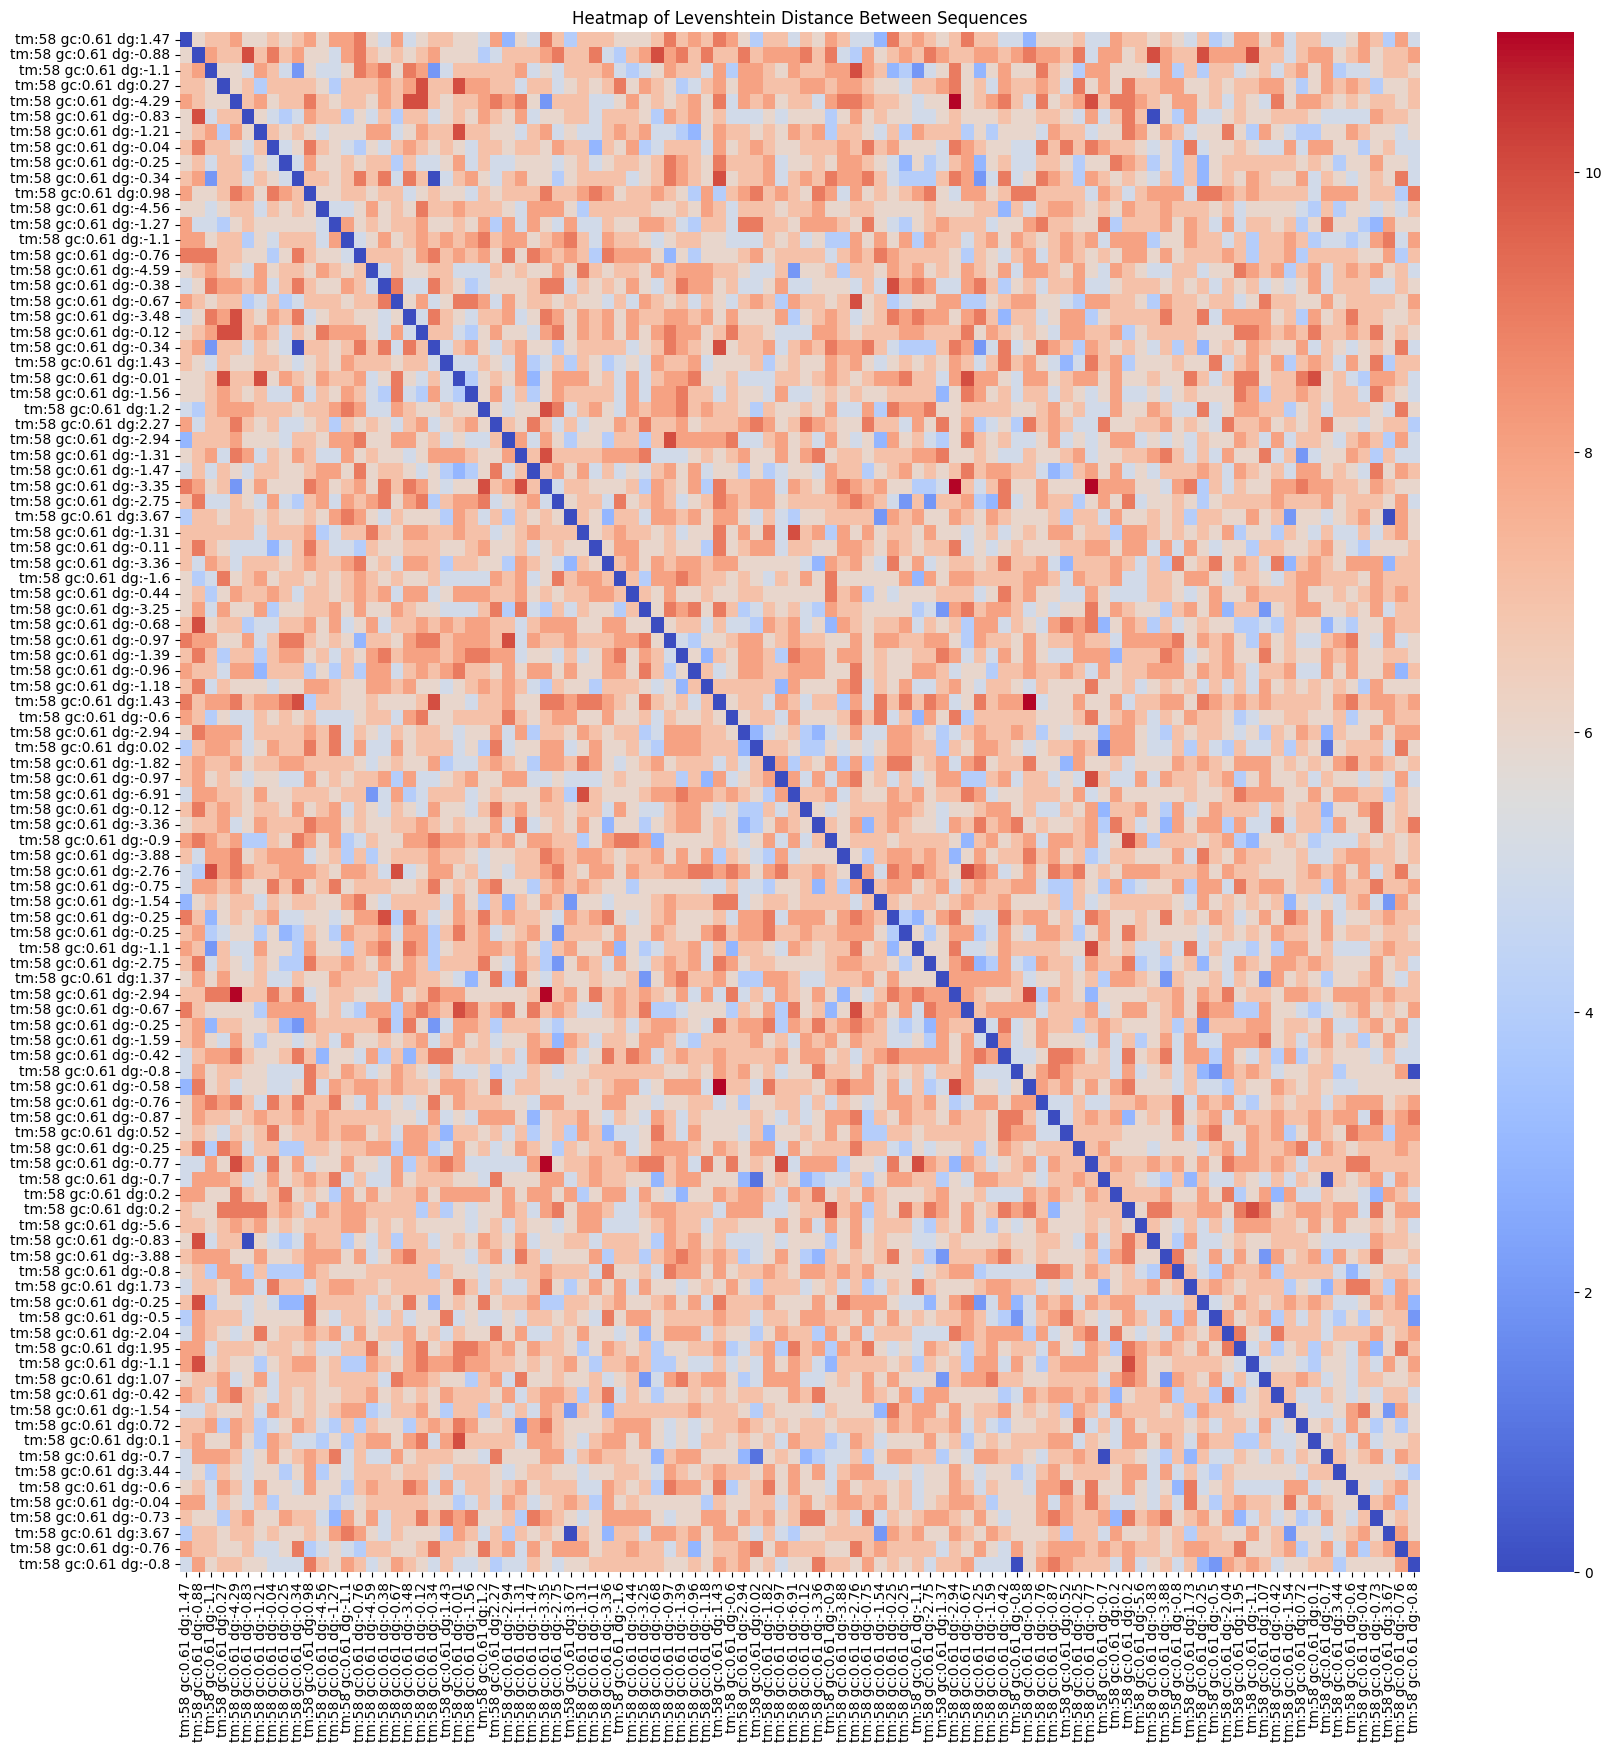

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
distance_matrix = np.zeros((num_sequences, num_sequences), dtype=int)

for i in range(num_sequences):
    for j in range(num_sequences):
        dist = Levenshtein.distance(sequences[i], sequences[j])
        distance_matrix[i, j] = dist
            
# Create a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(distance_matrix, xticklabels=seq_ids, yticklabels=seq_ids, annot=False, cmap='coolwarm')
plt.title("Heatmap of Levenshtein Distance Between Sequences")
plt.show()

In [19]:
def get_features(best_primer):
    gc = gc_content(best_primer)
    tm = melting_temp(best_primer)
    results = check_secondary_structure(best_primer)
    homodimer_tm = results['homodimer']['homodimer_dg']
    hairpin_tm = results['hairpin']['hairpin_dg']
    return gc, tm, homodimer_tm 
    
for i in range(num_sequences):
    for j in range(num_sequences):
        dist = Levenshtein.distance(sequences[i], sequences[j])
        distance_matrix[i, j] = dist
        if dist >= 6 and i != j:
            gc, tm, dg = get_features(sequences[i])
            if gc < 0.65 and dg > 0 and tm > 55:
                gc, tm, dg = get_features(sequences[j])
                if gc < 0.65 and dg > 0 and tm > 55:
                    if 'AAA' not in sequences[j] and 'GGG' not in sequences[j] and 'CCC' not in sequences[j] and 'TTT' not in sequences[j]:
                        if 'AAA' not in sequences[i] and 'GGG' not in sequences[i] and 'CCC' not in sequences[i] and 'TTT' not in sequences[i]:
                            print(sequences[j], sequences[i], dist, gc, tm, dg, i, j)
                            break

GGTCTCCGACGTACCAAC GGTCTCCGTGGTGATTCG 8 0.6111111111111112 58 0.9797075056018414 0 10
GGTCTCCGTGGTGATTCG GGTCTCCGACGTACCAAC 8 0.6111111111111112 58 1.4661842821398667 10 0
GGTCTCCGTGGTGATTCG GGTCTCCGACACTTGACG 7 0.6111111111111112 58 1.4661842821398667 21 0
GGTCTCCGACGTACCAAC GGTCTCCGTGATGGTCAC 7 0.6111111111111112 58 0.9797075056018414 24 10
GGTCTCCGACGTACCAAC GGTCTCCGTGGATTGACG 7 0.6111111111111112 58 0.9797075056018414 31 10
GGTCTCCGACGTACCAAC GGTCTCCGTGATCGGTTG 9 0.6111111111111112 58 0.9797075056018414 46 10
GGTCTCCGTGGTGATTCG GGTCTCCGATGTTCGTGG 6 0.6111111111111112 58 1.4661842821398667 61 0
GGTCTCCGTGGTGATTCG GGTCTCCGGACAATGACG 6 0.6111111111111112 58 1.4661842821398667 71 0
GGTCTCCGACACTTGACG GGTCTCCGTGATCCAACG 6 0.6111111111111112 58 1.4261800586647662 81 21
GGTCTCCGTGGTGATTCG GGTCTCCGATTGTCGTGG 6 0.6111111111111112 58 1.4661842821398667 87 0
GGTCTCCGACGTACCAAC GGTCTCCGTGGATTGACG 7 0.6111111111111112 58 0.9797075056018414 97 10


In [20]:
fwd_idx = 23
rev_idx = 20
seq_fwd = sequences[fwd_idx].replace(bsa1_site_fwd, '') + bsa1_site_fwd
seq_rev = bsa1_site_rv + 'C' + sequences[rev_idx].replace(bsa1_site_fwd, '') 

u.dp(['FWD:', seq_fwd])
print(get_features(seq_fwd), get_features(sequences[fwd_idx]))
u.dp(['REV:', seq_rev])
print(get_features(seq_rev),  get_features(sequences[rev_idx]))
dist = Levenshtein.distance(seq_fwd, seq_rev)
print(f'Distace between: {dist}')
primer_58_seqs = sequences

--------------------------------------------------------------------------------
                            FWD:	GACTGTTCGTCGGTCTCC	                            
--------------------------------------------------------------------------------
(0.6111111111111112, 58, 2.6350403659919626) (0.6111111111111112, 58, -1.5564793882722971)
--------------------------------------------------------------------------------
                            REV:	GGTCTCCCCGCTTGTAAG	                            
--------------------------------------------------------------------------------
(0.6111111111111112, 58, -0.3423887765347453) (0.6111111111111112, 58, -0.3423887765347453)


# Do the same except for a higher tm

In [ ]:
bsa1_site_fwd = 'GGTCTCC'
bsa1_site_rv =  'GGTCTC'

primer_min, primer_max = 18, 24
gc_optimal = 0.5
tm_optimal = 60
structure_dg = 0 # aim for greater than 0

options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9} 
num_sequences = 50
seq_ids = []
sequences = []
for sample in range(0, num_sequences):
    primer_len = 14 # 
    bounds = (np.zeros(primer_len), np.ones(primer_len) * 3)
    
    optimizer = ps.single.GlobalBestPSO(
        n_particles=50,
        dimensions=primer_len,
        options=options,
        bounds=bounds
    )

    best_cost, best_pos = optimizer.optimize(objective_function, iters=200)
    best_primer = decode_primer(best_pos)
    best_primer = best_primer + bsa1_site_fwd
    gc = gc_content(best_primer)
    tm = melting_temp(best_primer)
    results = check_secondary_structure(best_primer)
    homodimer_tm = results['homodimer']['homodimer_dg']
    hairpin_tm = results['hairpin']['hairpin_dg']
    seq_ids.append(f'tm:{tm} gc:{round(gc, 2)} dg:{round(homodimer_tm, 2)}')
    u.dp(['Best primer', len(best_primer), best_primer, f'tm:{tm}', f'gc:{gc}', f'dg:{homodimer_tm}'])
    sequences.append(best_primer)


2025-04-23 10:08:57,837 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|                                                                                                                                                                  |0/200/Users/arianemora/miniconda3/envs/oligo/lib/python3.10/site-packages/primer3/bindings.py:489: UserWarning: Function deprecated please use "calc_tm" instead
  return THERMO_ANALYSIS.calcTm(seq)
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.668
2025-04-23 10:08:59,129 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6675970252026109, best pos: [1.65911069 2.45807191 2.64438875 2.78993    0.90961812 0.02434141
 1.91290106 2.19474237 0.47966888 1.56422849 2.10083611 2.71430848
 2.79516007 2.35

--------------------------------------------------------------------------------
Best primer	21	GGTTCAGGAGGTTGGGTCTCC	tm:68	gc:0.6190476190476191	dg:0.923295782133303	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.651
2025-04-23 10:09:00,420 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6506728634290515, best pos: [2.29498897 2.52714896 1.60051381 2.93332318 1.52435167 0.38730137
 0.95629704 0.11900345 1.85512978 2.97925508 0.44199734 0.99646124
 1.68337389 2.19692957]
2025-04-23 10:09:00,423 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	21	GTGTGACAGTACGGGGTCTCC	tm:68	gc:0.6190476190476191	dg:2.055364226382128	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.732
2025-04-23 10:09:01,730 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7324070866600185, best pos: [2.19152388 1.788183   2.6258412  2.68784048 0.89741459 2.49024143
 2.27000197 0.37535683 0.85217046 2.92783555 0.73017877 0.35684885
 0.17993503 1.9043515 ]
2025-04-23 10:09:01,733 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	21	GGTTCGGACTCAAGGGTCTCC	tm:68	gc:0.6190476190476191	dg:0.12248428213330093	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.668
2025-04-23 10:09:02,952 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6675970252026109, best pos: [1.76922593 2.56401102 2.37534108 0.34665146 1.78926895 2.24175016
 1.56247339 1.79476712 0.4815319  1.55451139 2.88654463 2.6772608
 2.75296703 2.20387703]
2025-04-23 10:09:02,955 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	21	GTGAGGGGAGTTTGGGTCTCC	tm:68	gc:0.6190476190476191	dg:1.1923557821333044	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.804
2025-04-23 10:09:04,246 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.8037658017406354, best pos: [2.15986583 0.11560294 1.73119492 2.22350121 1.57209432 2.96294275
 2.90471593 2.91321274 2.22585389 1.69741006 2.70307526 1.41746723
 2.9358152  1.87179695]
2025-04-23 10:09:04,248 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	21	GAGGGTTTGGTCTGGGTCTCC	tm:68	gc:0.6190476190476191	dg:-0.13616877653802453	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=1.01
2025-04-23 10:09:05,573 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.0139084211341332, best pos: [1.31421438 1.77999056 0.39927303 1.53806479 0.96479326 0.31457171
 0.74973402 1.26970859 2.59300915 0.12625287 2.09272969 2.93467359
 2.89337302 2.18637829]
2025-04-23 10:09:05,576 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	21	CGAGCACCTAGTTGGGTCTCC	tm:68	gc:0.6190476190476191	dg:0.18513305866476845	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.565
2025-04-23 10:09:06,803 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5646018434218292, best pos: [2.03286929 2.51462365 2.51275701 1.55245917 1.06646841 1.85967312
 0.11041163 2.65807055 2.53810168 2.90604298 2.31554324 1.24251266
 2.88366969 1.6933654 ]
2025-04-23 10:09:06,805 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	21	GTTGCGATTTGCTGGGTCTCC	tm:66	gc:0.5714285714285714	dg:0.3229330586647775	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.617
2025-04-23 10:09:08,154 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6172723192066631, best pos: [2.47703086 1.96436633 2.64665156 2.7522229  2.72145584 1.8160884
 2.44638334 1.65995856 2.94252413 0.33863299 0.2532397  2.07023833
 1.54686403 1.81761087]
2025-04-23 10:09:08,157 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	21	GGTTTGGGTAAGGGGGTCTCC	tm:68	gc:0.6190476190476191	dg:0.11447305866477764	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.617
2025-04-23 10:09:09,404 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6172723192066631, best pos: [1.78330555 2.94041022 2.59894157 0.40953004 0.15653082 0.00909911
 0.78055371 0.02957449 1.85029488 2.26711544 2.00934594 2.42452258
 2.43214674 2.43613517]
2025-04-23 10:09:09,407 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	21	GTTAAACAGGGGGGGGTCTCC	tm:68	gc:0.6190476190476191	dg:0.11447305866477764	
--------------------------------------------------------------------------------


pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|200/200, best_cost=0.609
2025-04-23 10:09:10,769 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6088224128093889, best pos: [1.69197556 2.44216091 2.32347913 2.53452598 2.66804863 1.36643583
 2.59233121 2.75189755 2.62083142 1.66977054 2.07154393 1.81127711
 0.47748263 1.73386917]
2025-04-23 10:09:10,772 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


--------------------------------------------------------------------------------
Best primer	21	GGGTTCTTTGGGAGGGTCTCC	tm:68	gc:0.6190476190476191	dg:0.054041282133300735	
--------------------------------------------------------------------------------


pyswarms.single.global_best:  32%|██████████████████████████████████████████████                                                                                                  |64/200, best_cost=0.668

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
distance_matrix = np.zeros((num_sequences, num_sequences), dtype=int)

for i in range(num_sequences):
    for j in range(num_sequences):
        dist = Levenshtein.distance(sequences[i], sequences[j])
        distance_matrix[i, j] = dist
            
# Create a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(distance_matrix, xticklabels=seq_ids, yticklabels=seq_ids, annot=False, cmap='coolwarm')
plt.title("Heatmap of Levenshtein Distance Between Sequences")
plt.show()

In [21]:
def get_features(best_primer):
    gc = gc_content(best_primer)
    tm = melting_temp(best_primer)
    results = check_secondary_structure(best_primer)
    homodimer_tm = results['homodimer']['homodimer_dg']
    hairpin_tm = results['hairpin']['hairpin_dg']
    return gc, tm, homodimer_tm 
    
for i in range(num_sequences):
    for j in range(num_sequences):
        dist = Levenshtein.distance(sequences[i], sequences[j])
        distance_matrix[i, j] = dist
        if dist >= 7 and i != j:
            gc, tm, dg = get_features(sequences[i])
            if gc < 0.65 and dg > 0 and tm > 65:
                gc, tm, dg = get_features(sequences[j])
                if gc < 0.65 and dg > 0 and tm > 65:
                    if 'AAA' not in sequences[j] and 'GGG' not in sequences[j] and 'CCC' not in sequences[j] and 'TTT' not in sequences[j]:
                        if 'AAA' not in sequences[i] and 'GGG' not in sequences[i] and 'CCC' not in sequences[i] and 'TTT' not in sequences[i]:
                            u.dp([sequences[j], sequences[i], dist, gc, tm, dg, i, j, ])
                            break

In [ ]:
fwd_idx = 23
rev_idx = 20
seq_fwd = sequences[fwd_idx].replace(bsa1_site_fwd, '') + bsa1_site_fwd
seq_rev = bsa1_site_rv + 'C' + sequences[rev_idx].replace(bsa1_site_fwd, '') 

u.dp(['FWD:', seq_fwd])
print(get_features(seq_fwd), get_features(sequences[fwd_idx]))
u.dp(['REV:', seq_rev])
print(get_features(seq_rev),  get_features(sequences[rev_idx]))
dist = Levenshtein.distance(seq_fwd, seq_rev)
print(f'Distace between: {dist}')